In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [321]:
# To preprocess as Morgan et. al.
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [277]:
plt.rc("font", size=16)

# 1D GPR Example

# Perovskite stability prediction

## Load Data

In [7]:
cdata = pd.read_csv("../data/c_0_train.csv", index_col=0)
ddata = pd.read_csv("../data/d_0_train.csv", index_col=0)

In [10]:
ddata

,numberofelements,Asite_At. #_weighted_avg,Asite_Period_weighted_avg,Asite_Group_weighted_avg,Asite_valence_weighted_avg,Asite_IsHexagonal_weighted_avg,Asite_IsBCC_weighted_avg,Asite_IsCubic_weighted_avg,Asite_IsFCC_weighted_avg,Asite_IsOrthorhombic_weighted_avg,...,Bsite_NdValence_range,Bsite_NfUnfilled_range,Bsite_NfValence_range,Bsite_NpUnfilled_range,Bsite_NpValence_range,Bsite_NsUnfilled_range,Bsite_NsValence_range,Bsite_NUnfilled_range,EnergyAboveHull,Formation_energy
1.0,4.0,40.25,5.125,2.00,2.00,0.00,0.125,0.0,0.875,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.747707,-2.113335
2.0,5.0,64.25,6.000,5.75,3.25,0.50,0.250,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,106.702335,-1.311863
3.0,4.0,29.00,4.500,2.00,2.00,0.00,0.250,0.0,0.750,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,171.608093,-1.435607
4.0,5.0,55.50,5.750,5.00,2.50,0.75,0.250,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,284.898190,-0.868639
5.0,4.0,63.50,6.000,2.75,2.75,0.75,0.250,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,270.007913,-1.746806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1925.0,4.0,39.00,5.000,3.00,3.00,1.00,0.000,0.0,0.000,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.588513,-2.438274
1926.0,4.0,39.00,5.000,3.00,3.00,1.00,0.000,0.0,0.000,0.0,...,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.000000,-2.509888
1927.0,4.0,39.00,5.000,3.00,3.00,1.00,0.000,0.0,0.000,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.000000,-2.479151
1928.0,4.0,39.00,5.000,3.00,3.00,1.00,0.000,0.0,0.000,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.000000,-2.441538


## Preprocess Data

In [12]:
# select continuous features
Xc = cdata[cdata.columns[:-2]]
Xd = ddata[ddata.columns[:-2]]
y = cdata[cdata.columns[-2]]
y1 = y.copy()
y2 = cdata[cdata.columns[-1]]
y[y < 40] = 1
y[y > 40] = 0

In [15]:
y.name = "Stability"

In [16]:
X_total = pd.concat([Xc, Xd], axis=1)
X_total

,goldschmidt_TF,goldschmidt_TF_ionic,octahedral_factor,octahedral_factor_ionic,A_O,B_O,A_B,num_of_atoms_Asite0,shannon_radii_Asite0,Asite0_Ionic Radius (angstroms),...,Bsite_IsNonmetal_range,Bsite_NdUnfilled_range,Bsite_NdValence_range,Bsite_NfUnfilled_range,Bsite_NfValence_range,Bsite_NpUnfilled_range,Bsite_NpValence_range,Bsite_NsUnfilled_range,Bsite_NsValence_range,Bsite_NUnfilled_range
1.0,1.021823,0.976828,0.414286,0.385714,2.86125,1.98000,2.04125,1.0,1.610,1.42,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.987385,0.889057,0.378571,0.464286,2.69500,1.93000,1.82500,2.0,1.610,1.42,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.976009,0.908360,0.452857,0.392857,2.80750,2.03400,2.04150,2.0,1.610,1.42,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,1.026809,0.865275,0.342857,0.492857,2.73000,1.88000,1.81000,2.0,1.610,1.42,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.909001,0.916519,0.452857,0.392857,2.61475,2.03400,1.84875,2.0,1.610,1.42,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1925.0,0.886682,0.875853,0.409821,0.395536,2.47500,1.97375,1.64875,8.0,1.075,1.02,...,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1926.0,0.885561,0.877538,0.411607,0.392857,2.47500,1.97625,1.65125,8.0,1.075,1.02,...,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1927.0,0.880880,0.881493,0.419107,0.386607,2.47500,1.98675,1.66175,8.0,1.075,1.02,...,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1928.0,0.889499,0.873618,0.405357,0.399107,2.47500,1.96750,1.64250,8.0,1.075,1.02,...,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [18]:
feats = pd.read_csv("../data/RFE_clf_indices.txt", names = ["column_ids"])
feats

,column_ids
0,119
1,105
2,547
3,396
4,96
...,...
786,667
787,744
788,585
789,590


In [85]:
selfeats = feats.iloc[:10].column_ids.array
selfeats

<PandasArray>
[119, 105, 547, 396, 96, 118, 680, 377, 135, 88]
Length: 10, dtype: int64

In [86]:
Xt = X_total.iloc[:, selfeats]
Xt

,First Ionization Potential (V)_AB_avg,GSenergy_pa_AB_avg,Asite_IsHalogen_weighted_avg,Asite_Atomic Volume (cm³/mol)_min,BCCefflatcnt_AB_avg,n_ws^third_AB_avg,Bsite0_IsNoblegas,Asite_BCCenergy_pa_min,at. wt._AB_diff,Bsite0_Electro- negativity
1.0,6.187312,-5.326081,0.0,33.7,7.730568,1.238125,0.0,-1.923522,21.446125,1.63
2.0,6.857625,-5.470804,0.0,20.8,7.066584,1.421250,0.0,-4.648540,49.049125,1.88
3.0,6.878875,-5.113806,0.0,25.9,7.179786,1.327500,0.0,-1.927259,4.272000,1.83
4.0,6.958125,-4.308582,0.0,13.1,6.929113,1.431250,0.0,-4.648540,37.097725,1.91
5.0,6.814000,-6.108765,0.0,19.0,7.011255,1.443750,0.0,-4.455381,50.180250,1.83
...,...,...,...,...,...,...,...,...,...,...
1925.0,6.630000,-7.585751,0.0,19.8,6.959018,1.431875,0.0,-6.340298,18.482719,1.63
1926.0,6.561625,-7.737334,0.0,19.8,6.966861,1.430625,0.0,-6.340298,18.916294,1.63
1927.0,6.630625,-7.661069,0.0,19.8,6.962176,1.433125,0.0,-6.340298,18.675606,1.63
1928.0,6.615937,-7.489872,0.0,19.8,6.957805,1.431875,0.0,-6.340298,18.497706,1.63


In [87]:
ye = y1[y1 < 400]
ye

1.0        29.747707
2.0       106.702335
3.0       171.608093
4.0       284.898190
5.0       270.007913
             ...    
1925.0      1.588513
1926.0      0.000000
1927.0      0.000000
1928.0      0.000000
1929.0      0.000000
Name: EnergyAboveHull, Length: 1918, dtype: float64

In [88]:
yf = y2[y1 < 400]
yf

1.0      -2.113335
2.0      -1.311863
3.0      -1.435607
4.0      -0.868639
5.0      -1.746806
            ...   
1925.0   -2.438274
1926.0   -2.509888
1927.0   -2.479151
1928.0   -2.441538
1929.0   -2.520681
Name: Formation_energy, Length: 1918, dtype: float64

In [89]:
xt = Xt[y1 < 400]
xt

,First Ionization Potential (V)_AB_avg,GSenergy_pa_AB_avg,Asite_IsHalogen_weighted_avg,Asite_Atomic Volume (cm³/mol)_min,BCCefflatcnt_AB_avg,n_ws^third_AB_avg,Bsite0_IsNoblegas,Asite_BCCenergy_pa_min,at. wt._AB_diff,Bsite0_Electro- negativity
1.0,6.187312,-5.326081,0.0,33.7,7.730568,1.238125,0.0,-1.923522,21.446125,1.63
2.0,6.857625,-5.470804,0.0,20.8,7.066584,1.421250,0.0,-4.648540,49.049125,1.88
3.0,6.878875,-5.113806,0.0,25.9,7.179786,1.327500,0.0,-1.927259,4.272000,1.83
4.0,6.958125,-4.308582,0.0,13.1,6.929113,1.431250,0.0,-4.648540,37.097725,1.91
5.0,6.814000,-6.108765,0.0,19.0,7.011255,1.443750,0.0,-4.455381,50.180250,1.83
...,...,...,...,...,...,...,...,...,...,...
1925.0,6.630000,-7.585751,0.0,19.8,6.959018,1.431875,0.0,-6.340298,18.482719,1.63
1926.0,6.561625,-7.737334,0.0,19.8,6.966861,1.430625,0.0,-6.340298,18.916294,1.63
1927.0,6.630625,-7.661069,0.0,19.8,6.962176,1.433125,0.0,-6.340298,18.675606,1.63
1928.0,6.615937,-7.489872,0.0,19.8,6.957805,1.431875,0.0,-6.340298,18.497706,1.63


In [90]:
y = y[y1 < 400]
y

1.0       1.0
2.0       0.0
3.0       0.0
4.0       0.0
5.0       0.0
         ... 
1925.0    1.0
1926.0    1.0
1927.0    1.0
1928.0    1.0
1929.0    1.0
Name: Stability, Length: 1918, dtype: float64

In [91]:
scaler = preprocessing.StandardScaler().fit(xt)

In [92]:
xscl = scaler.transform(xt)
xscl = pd.DataFrame(xscl, columns = xt.columns)
xscl

,First Ionization Potential (V)_AB_avg,GSenergy_pa_AB_avg,Asite_IsHalogen_weighted_avg,Asite_Atomic Volume (cm³/mol)_min,BCCefflatcnt_AB_avg,n_ws^third_AB_avg,Bsite0_IsNoblegas,Asite_BCCenergy_pa_min,at. wt._AB_diff,Bsite0_Electro- negativity
0,-1.082046,0.257628,0.0,1.413683,1.032857,-1.122267,0.0,1.320323,-0.381019,-0.195136
1,0.872407,0.114270,0.0,-0.269275,-0.598522,0.857514,0.0,-0.311416,1.404958,1.115336
2,0.934367,0.467903,0.0,0.396080,-0.320390,-0.156026,0.0,1.318085,-1.492224,0.853242
3,1.165439,1.265536,0.0,-1.273832,-0.936284,0.965625,0.0,-0.311416,0.631675,1.272593
4,0.745208,-0.517678,0.0,-0.504107,-0.734464,1.100763,0.0,-0.195752,1.478145,0.853242
...,...,...,...,...,...,...,...,...,...,...
1913,0.208713,-1.980740,0.0,-0.399737,-0.862806,0.972382,0.0,-1.324439,-0.572758,-0.195136
1914,0.009350,-2.130894,0.0,-0.399737,-0.843537,0.958868,0.0,-1.324439,-0.544705,-0.195136
1915,0.210536,-2.055348,0.0,-0.399737,-0.855047,0.985896,0.0,-1.324439,-0.560278,-0.195136
1916,0.167711,-1.885765,0.0,-0.399737,-0.865787,0.972382,0.0,-1.324439,-0.571788,-0.195136


## Train test split

In [179]:
N = 200
xtr, xtest, ytr, ytest = train_test_split(xscl, yf, test_size=N)

In [180]:
K = 1.0 * RBF(1.0) + WhiteKernel(0.5)
gpr = GaussianProcessRegressor(kernel=K)
gpr.fit(xtr, ytr)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.5))

In [316]:
ypred, sd = gpr.predict(xtest, return_std=True)

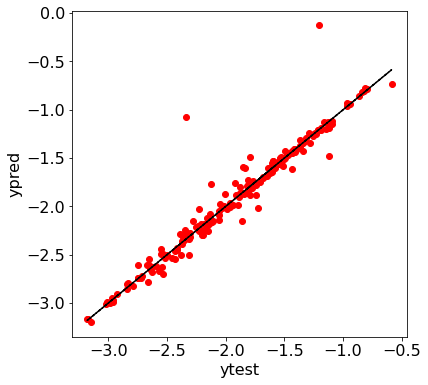

In [317]:
plt.figure(figsize=(6,6))

plt.plot(ytest, ypred, 'ro')
plt.plot(ytest, ytest, 'k--')
plt.ylabel("ypred")
plt.xlabel("ytest")
plt.show()

In [319]:
from sklearn.metrics import r2_score

In [320]:
r2_score(ytest, ypred)

0.9364728931000883

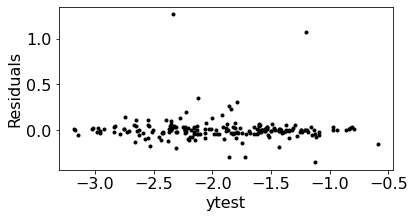

In [318]:
plt.figure(figsize=(6,3))

plt.plot(ytest, ypred - ytest, 'k.')
plt.ylabel("Residuals")
plt.xlabel("ytest")
plt.show()

In [310]:
ypred = pd.DataFrame(ypred, columns = ["ypred"])
sd = pd.DataFrame(sd, columns = ["sd"])

In [311]:
df = pd.concat([xtest.reset_index(), ypred, sd], axis=1)
df = df.set_index("index")
df

,First Ionization Potential (V)_AB_avg,GSenergy_pa_AB_avg,Asite_IsHalogen_weighted_avg,Asite_Atomic Volume (cm³/mol)_min,BCCefflatcnt_AB_avg,n_ws^third_AB_avg,Bsite0_IsNoblegas,Asite_BCCenergy_pa_min,at. wt._AB_diff,Bsite0_Electro- negativity,ypred,sd
index,,,,,,,,,,,,
761,0.081150,0.289098,0.0,-0.278408,-0.209627,0.033168,0.0,-0.399634,0.057494,-0.614487,-1.602675,0.071172
818,0.492997,-0.387349,0.0,-0.380168,-0.929726,1.371041,0.0,-0.399634,0.911205,1.115336,-1.852946,0.058067
834,1.236145,0.526546,0.0,-1.782634,-1.279609,1.208874,0.0,-0.399634,0.319200,1.272593,-1.547442,0.074100
914,0.151127,1.337511,0.0,-0.278408,0.162726,-0.237109,0.0,-0.399634,1.382573,-1.872540,-2.285612,0.101040
1670,0.631130,-0.290818,0.0,-0.399737,-0.072633,0.222362,0.0,-1.324439,0.016619,1.115336,-1.557695,0.065088
...,...,...,...,...,...,...,...,...,...,...,...,...
1732,0.974094,0.388929,0.0,-0.399737,-0.455589,0.492640,0.0,-1.324439,-0.815902,1.115336,-1.373472,0.067674
800,0.011172,-1.331458,0.0,-0.543245,-0.971709,0.627778,0.0,-0.399634,1.158295,-0.614487,-2.299465,0.068067
1853,1.493459,-1.863037,0.0,-0.399737,-1.263078,1.384555,0.0,-1.324439,-0.691787,0.853242,-2.257556,0.073012


In [312]:
df = (df
          .assign(ylo = lambda x: x.ypred - 1.96 * x.sd)
          .assign(yhi = lambda x: x.ypred + 1.96 * x.sd)

     )
df

,First Ionization Potential (V)_AB_avg,GSenergy_pa_AB_avg,Asite_IsHalogen_weighted_avg,Asite_Atomic Volume (cm³/mol)_min,BCCefflatcnt_AB_avg,n_ws^third_AB_avg,Bsite0_IsNoblegas,Asite_BCCenergy_pa_min,at. wt._AB_diff,Bsite0_Electro- negativity,ypred,sd,ylo,yhi
index,,,,,,,,,,,,,,
761,0.081150,0.289098,0.0,-0.278408,-0.209627,0.033168,0.0,-0.399634,0.057494,-0.614487,-1.602675,0.071172,-1.742172,-1.463178
818,0.492997,-0.387349,0.0,-0.380168,-0.929726,1.371041,0.0,-0.399634,0.911205,1.115336,-1.852946,0.058067,-1.966757,-1.739135
834,1.236145,0.526546,0.0,-1.782634,-1.279609,1.208874,0.0,-0.399634,0.319200,1.272593,-1.547442,0.074100,-1.692678,-1.402206
914,0.151127,1.337511,0.0,-0.278408,0.162726,-0.237109,0.0,-0.399634,1.382573,-1.872540,-2.285612,0.101040,-2.483650,-2.087573
1670,0.631130,-0.290818,0.0,-0.399737,-0.072633,0.222362,0.0,-1.324439,0.016619,1.115336,-1.557695,0.065088,-1.685268,-1.430121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732,0.974094,0.388929,0.0,-0.399737,-0.455589,0.492640,0.0,-1.324439,-0.815902,1.115336,-1.373472,0.067674,-1.506114,-1.240831
800,0.011172,-1.331458,0.0,-0.543245,-0.971709,0.627778,0.0,-0.399634,1.158295,-0.614487,-2.299465,0.068067,-2.432876,-2.166054
1853,1.493459,-1.863037,0.0,-0.399737,-1.263078,1.384555,0.0,-1.324439,-0.691787,0.853242,-2.257556,0.073012,-2.400660,-2.114452


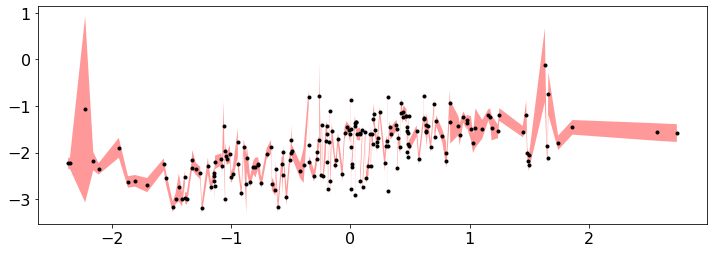

In [313]:
df = (df
      .set_index(df.columns[0])
      .sort_index()
)

plt.figure(figsize=(12, 4))
plt.plot(df.index, df.ypred, 'k.')
plt.fill_between(df.index, df.ylo, df.yhi, fc='r', alpha=0.4)
plt.show()